In [ ]:
# add all three with a flag

In [1]:
import pandas as pd
import glob
import numpy as np
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# List all CSV files in the directory
csv_files_vert = glob.glob("/home/ashmitha/Downloads/data_env_vert_freq/enve_f_data_vert_*.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each CSV file, read it into a DataFrame, and append it to the list
for file in csv_files_vert:
    df = pd.read_csv(file, header=None)
    dfs.append(df)

# Concatenate all DataFrames in the list into one DataFrame
data_env = pd.concat(dfs, ignore_index=True)
data_env = data_env.iloc[:, [0] + list(range(5, data_env.shape[1]-1))]

nan_values = data_env.isna().sum()

# Display the number of NaN values for each column
print("NaN values in each column:")
print(nan_values)


NaN values in each column:
0       0
5       2
6       2
7       0
8       2
       ..
246    22
247    22
248    22
249    22
250    22
Length: 247, dtype: int64


In [3]:
data_env = data_env.dropna()


In [4]:
data_env.head()

,0,5,6,7,8,9,10,11,12,13,...,241,242,243,244,245,246,247,248,249,250
0,Acadia_RSN2304.mat,6.820000e-11,9.120000e-11,1.940000e-10,2.040000e-10,2.970000e-10,1.610000e-10,1.380000e-10,1.260000e-10,1.070000e-10,...,4.250000e-16,2.020000e-15,2.230000e-15,2.190000e-15,2.350000e-15,1.910000e-16,5.470000e-16,6.800000e-16,5.610000e-16,1.210000e-15
1,Acadia_RSN2305.mat,1.320000e-10,1.500000e-10,1.800000e-10,1.600000e-10,1.530000e-10,1.730000e-10,1.620000e-10,1.650000e-10,1.310000e-10,...,6.770000e-14,3.020000e-14,4.520000e-14,5.940000e-14,6.080000e-14,7.820000e-14,4.660000e-14,2.700000e-14,3.600000e-14,3.120000e-14
2,Acadia_RSN2306.mat,1.370000e-10,9.740000e-11,2.460000e-10,1.550000e-10,1.500000e-10,1.320000e-10,1.330000e-10,1.290000e-10,2.110000e-10,...,9.250000e-16,1.140000e-15,1.190000e-15,6.650000e-15,6.290000e-15,1.490000e-15,1.560000e-15,5.570000e-16,5.620000e-16,9.610000e-16
3,Acadia_RSN2307.mat,3.270000e-11,4.230000e-11,5.140000e-11,4.450000e-11,6.280000e-11,6.400000e-11,8.370000e-11,8.550000e-11,8.910000e-11,...,5.440000e-13,5.010000e-13,5.850000e-13,7.020000e-13,6.630000e-13,6.550000e-13,5.410000e-13,4.380000e-13,4.020000e-13,2.170000e-13
4,Acadia_RSN2308.mat,1.360000e-11,1.770000e-11,3.370000e-11,4.090000e-11,2.490000e-11,3.870000e-11,5.720000e-11,6.210000e-11,6.410000e-11,...,1.200000e-13,6.960000e-14,5.400000e-14,6.040000e-14,6.500000e-14,6.690000e-14,7.070000e-14,7.660000e-14,6.610000e-14,3.580000e-14


In [4]:
def modify_filename(filename):
    parts = filename.split("_")
    new_filename = "_".join(parts[:-1]) + "_" + parts[-1][3:7]
    return new_filename

# Apply the modification to each filename in the 'Filename' column
data_env['id'] = data_env[0].apply(modify_filename)

In [16]:
data_env.shape

(3204, 248)

In [5]:
data_input = pd.read_excel("/home/ashmitha/seismic_data/data/part3/nga_flstfile.xlsx")

In [6]:
input_vaiables = pd.DataFrame()

input_vaiables["Mw"] = data_input['Earthquake Magnitude']
input_vaiables["Rrup"] = data_input['ClstD (km)']
input_vaiables["log(Rrup)"] = np.log(data_input['ClstD (km)'])
input_vaiables["VS30"] = data_input['Preferred VS30 (m/sec)']
input_vaiables["focal_depth"] = data_input['Joyner-Boore Dist. (km)']
input_vaiables["eq_name"] = data_input["Earthquake Name"]
input_vaiables["eq_id"] = data_input["Record Sequence Number"]

In [7]:
input_vaiables["id"] = input_vaiables["eq_name"].str[:-11] + "_" + input_vaiables["eq_id"].astype(str).str[:-2]
combined_data = pd.merge(data_env, input_vaiables, on="id")


In [8]:
X = combined_data[["Mw", "log(Rrup)", "VS30", "focal_depth", "Rrup"]].copy()
y = np.log(combined_data.iloc[:, 5:247].copy())
X["log(focal_depth)"] = np.log(X["focal_depth"])
X["log(VS30)"] = np.log(X["VS30"])
X = X[["Mw", "log(Rrup)", "log(VS30)", "focal_depth", "Rrup"]]

In [21]:
score = []

In [22]:
import csv

In [37]:
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.05, 0.1]
reg_alphas = [0.01, 0.1, 1]

# Open the CSV file outside the loop
with open("model_result_time_1.csv", 'a', newline='') as file:
    writer = csv.writer(file)

    # Iterate over each combination of hyperparameters
    for depth in max_depths:
        for lr in learning_rates:
            for alpha in reg_alphas:
            # for i in range(100):
                print(f"Testing max_depth={depth}, learning_rate={lr}, reg_alpha={alpha}")
                
                # Split the data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

                # Parameters for the XGBoost model
                params = {
                    'objective': 'reg:squarederror',
                    'max_depth': depth,
                    'learning_rate': lr,
                    'n_estimators': 1000,
                    'min_child_weight': 5,
                    'gamma': 0,
                    'subsample': 0.8,
                    'scale_pos_weight': 1,
                    'nthread': 1,
                    'seed': 0,
                    'reg_alpha': alpha
                }

                # Initialize and train the XGBoost model
                model = xgb.XGBRegressor(**params)
                model.fit(X_train, y_train)

                # Make predictions and evaluate
                y_pred = model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)

                print([depth, lr, alpha, r2, mse, mae])

                # Write results to CSV
                writer.writerow([depth, lr, alpha, r2, mse, mae])

Testing max_depth=3, learning_rate=0.01, reg_alpha=0.01
[3, 0.01, 0.01, 0.7365880194992668, 5.620705169447988, 1.7494003785011079]
Testing max_depth=3, learning_rate=0.01, reg_alpha=0.1
[3, 0.01, 0.1, 0.7365654986913741, 5.621153942669642, 1.749551538370968]
Testing max_depth=3, learning_rate=0.01, reg_alpha=1
[3, 0.01, 1, 0.7362422222488788, 5.627262851552694, 1.7507175744125214]
Testing max_depth=3, learning_rate=0.05, reg_alpha=0.01
[3, 0.05, 0.01, 0.7481284598882032, 5.358491537575492, 1.6795619154337014]
Testing max_depth=3, learning_rate=0.05, reg_alpha=0.1
[3, 0.05, 0.1, 0.7480710316027298, 5.359435054632525, 1.679200639952844]
Testing max_depth=3, learning_rate=0.05, reg_alpha=1
[3, 0.05, 1, 0.7479161039502431, 5.362516568423655, 1.6819621003249052]
Testing max_depth=3, learning_rate=0.1, reg_alpha=0.01
[3, 0.1, 0.01, 0.7387187261343557, 5.5524680366811205, 1.688279224321895]
Testing max_depth=3, learning_rate=0.1, reg_alpha=0.1
[3, 0.1, 0.1, 0.738543211193915, 5.55604383074260

In [54]:
for i in range(700, 2000, 200):
    print(i)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

    # Define the XGBoost model
    model = xgb.XGBRegressor()

    params = {
        'objective': 'reg:squarederror',  # objective function for regression
        'max_depth': 5,
        'learning_rate': 0.01,
        'n_estimators': i,
        'min_child_weight': 5,
        'gamma' : 0,
        'subsample' : 0.8,
        'scale_pos_weight' : 1,
        'nthread' : 1,
        'scale_pos_weight' : 1,
        'seed' : 0,
        'reg_alpha' : 1e-2,
    }

    # Define the XGBoost model with parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    with open("model_result_time_estimators.csv", 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i, r2, mse, mae])
    

700
900
1100
1300
1500


: 

In [48]:
data_model = pd.read_csv("./model_result_time_1.csv")

In [49]:
data_model.head()

,depth,lr,alpha,r2,mse,mae
0,3,0.01,0.01,0.736588,5.620705,1.749400
1,3,0.01,0.10,0.736565,5.621154,1.749552
2,3,0.01,1.00,0.736242,5.627263,1.750718
3,3,0.05,0.01,0.748128,5.358492,1.679562
4,3,0.05,0.10,0.748071,5.359435,1.679201


In [52]:
sorted_data_model = data_model.sort_values(by="r2", ascending=False)

KeyError: 'r2'

In [14]:
sorted_data_model.head()

,i,r2,mse,mae
82,82,0.751587,5.276294,1.667747
36,36,0.746647,5.986572,1.777254
17,17,0.743980,5.612195,1.734769
14,14,0.735355,6.047124,1.747601
25,25,0.734876,6.496175,1.812202


In [275]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=82)

# Define the XGBoost model
model_1 = xgb.XGBRegressor()

params = {
    'objective': 'reg:squarederror',  # objective function for regression
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'min_child_weight': 3,
    'gamma' : 0.2,
    'subsample' : 0.6,
    'scale_pos_weight' : 1,
    'nthread' : 1,
    'scale_pos_weight' : 1,
    'seed' : 0,
    'reg_alpha' : 0.005,
}

# Define the XGBoost model with parameters
model_1 = xgb.XGBRegressor(**params)

# Train the model
model_1.fit(X_train, y_train)
print("train")

# Make predictions on the testing set
y_pred = model_1.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print(r2)
mse = mean_squared_error(y_test, y_pred)
print(mse)
mae = mean_absolute_error(y_test, y_pred)

train
0.7492144708810631
0.2454116395811015


In [281]:
import torch
import torch.nn as nn

# defining the network
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        # Intermediate linear layer with activation
        self.fc1 = nn.Linear(hidden_size, 150)
        self.tanh = nn.LeakyReLU()

        # Second LSTM layer
        self.lstm2 = nn.LSTM(150, 200, num_layers=1, batch_first=True)
        # Final linear layer for output
        self.fc2 = nn.Linear(200, output_size)

    def forward(self, x):
        # Assuming x is of shape (batch_size, sequence_length, features)
        # Initial states
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm1(x, (h0, c0))
        
        out = self.tanh(self.fc1(out))

        # Passing to second LSTM layer
        h1 = torch.zeros(1, x.size(0), 200).to(x.device)
        c1 = torch.zeros(1, x.size(0), 200).to(x.device)
        out, _ = self.lstm2(out, (h1, c1))

        out = self.fc2(out)
        return out


# Example :
model = LSTMModel(5, 100, 242)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []





In [293]:
import torch
import torch.nn as nn

# defining the network
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        # Intermediate linear layer with activation
        self.fc1 = nn.Linear(hidden_size, 242)
        self.tanh = nn.LeakyReLU()

        # Second LSTM layer
        # Final linear layer for output

    def forward(self, x):
        # Assuming x is of shape (batch_size, sequence_length, features)
        # Initial states
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm1(x, (h0, c0))
        
        out = self.tanh(self.fc1(out))

    
        return out


# Example :
model = LSTMModel(5, 150, 242)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []





In [235]:
X.head()

,Mw,log(Rrup),log(VS30),focal_depth,Rrup
0,3.87,5.882403,7.600902,358.67,358.67
1,3.87,5.928365,7.600902,375.54,375.54
2,3.87,5.969653,7.600902,391.37,391.37
3,3.87,5.959045,7.600902,387.24,387.24
4,3.87,5.959045,7.600902,387.24,387.24


In [236]:
y.head()

,9,10,11,12,13,14,15,16,17,18,...,241,242,243,244,245,246,247,248,249,250
0,-21.937289,-22.549617,-22.703767,-22.794739,-22.958192,-22.930541,-22.640589,-22.689379,-22.725746,-22.763487,...,-35.394443,-33.835679,-33.736775,-33.754875,-33.684361,-36.194258,-35.142083,-34.924439,-35.116811,-34.348156
1,-22.600583,-22.477730,-22.543425,-22.525076,-22.755824,-22.778991,-22.317815,-22.255743,-22.255743,-22.308011,...,-30.323690,-31.130934,-30.727679,-30.454482,-30.431187,-30.179507,-30.697176,-31.242940,-30.955257,-31.098358
2,-22.620386,-22.748219,-22.740672,-22.771209,-22.279163,-22.283914,-22.197299,-22.109560,-22.025219,-21.968061,...,-34.616738,-34.407748,-34.364823,-32.644160,-32.699815,-34.140000,-34.094091,-35.123966,-35.115030,-34.578557
3,-23.491066,-23.472138,-23.203782,-23.182505,-23.141262,-23.126777,-22.771209,-22.877431,-22.843529,-22.810740,...,-28.239827,-28.322170,-28.167165,-27.984843,-28.042001,-28.054141,-28.245357,-28.456557,-28.542324,-29.158879
4,-23.488661,-23.485084,-23.211543,-23.192509,-23.126676,-23.113787,-22.787837,-22.872040,-22.826517,-22.820969,...,-28.252438,-28.257053,-27.971228,-28.054294,-28.239308,-28.167885,-28.291209,-28.426906,-28.496082,-28.913504


In [237]:
y.shape

(2339, 242)

In [306]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and transform the output data
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=82)

# X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# X_train = X_train.unsqueeze(1)
# y_train = y_train.unsqueeze(2)

dataset = TensorDataset(X_train, y_train)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [210]:
# Initialize SVM regressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize SVM regressor
svr = SVR(kernel='rbf', C=1.0, epsilon=0.5, gamma=0.1)

# Wrap SVR in a MultiOutputRegressor to handle multiple outputs
multioutput_regressor = MultiOutputRegressor(svr)

# Train the model
multioutput_regressor.fit(X_train, y_train)

# Make predictions
y_pred = multioutput_regressor.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 7.12


In [211]:
r2 = r2_score(y_test, y_pred)
r2

0.6680866814365097

In [122]:
for X_batch, y_batch in dataloader:
    
    print("Batch X shape:", X_batch.shape)  # Should be [batch_size, 1, 6]
    print("Batch Y shape:", y_batch.shape)  # Should be [batch_size, output_seq_len, output_features]
    break

Batch X shape: torch.Size([64, 5])
Batch Y shape: torch.Size([64, 242])


In [199]:
y_train.shape

torch.Size([1871, 242, 1])

In [200]:
X_train.shape

torch.Size([1871, 1, 6])

In [ ]:
# ANN Relu
Mean square error: 7.1681430970092705
R2 Score: 0.6594229519855669

# ANN Tanh 
Mean square error: 9.34938890752678
R2 Score: 0.5334892948311023

In [214]:
# Define the network architecture
class SpectrumPredictor_1(nn.Module):
    def __init__(self):
        super(SpectrumPredictor_1, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # 6 features input
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 242)  # output_size depends on the response spectrum resolution
        

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
# Example :
model = SpectrumPredictor_1()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


In [223]:
# Define the network architecture
class SpectrumPredictor_2(nn.Module):
    def __init__(self):
        super(SpectrumPredictor_2, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # 6 features input
        self.fc4 = nn.Linear(128, 242)  # output_size depends on the response spectrum resolution
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc4(x)
        return x
    
# Example :
model = SpectrumPredictor_2()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


In [232]:
# Define the network architecture
class SpectrumPredictor_3(nn.Module):
    def __init__(self):
        super(SpectrumPredictor_3, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # 6 features input
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 128)
        self.fc6 = nn.Linear(128, 242)  # output_size depends on the response spectrum resolution
        

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
# Example :
model = SpectrumPredictor_3()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


In [308]:
#FINAL

class SpectrumPredictor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SpectrumPredictor, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 242)

        # self.relu = nn.LeakyReLU()
        self.relu = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        # x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        # x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        # x = self.dropout(x)
        x = self.fc4(x)
        return x
    
model = SpectrumPredictor()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


In [297]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, output_seq_len=242):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_seq_len = output_seq_len
        self.num_layers = num_layers

        # Encoder LSTM
        self.lstm_encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Decoder LSTM
        self.lstm_decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Encoder forward pass
        _, (hn, cn) = self.lstm_encoder(x, (h0, c0))

        # Prepare decoder input (repeat last hidden state across output sequence length)
        decoder_input = torch.zeros(batch_size, self.output_seq_len, self.hidden_size).to(x.device)
        decoder_input = decoder_input + hn[-1].unsqueeze(1)  # Adjust hn to match decoder input requirements

        # Decoder forward pass
        decoder_output, _ = self.lstm_decoder(decoder_input, (hn, cn))

        # Pass each time step through the fully connected layer
        out = self.fc(decoder_output)
        return out


# Model initialization
input_size = 5
hidden_size = 100
output_size = 1
num_layers = 1

model = Seq2SeqLSTM(input_size, hidden_size, output_size, num_layers)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# optimizer_adagrad = torch.optim.Adagrad(model.parameters(), lr=) ----
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

criterion = nn.MSELoss()
# criterion = torch.nn.HingeEmbeddingLoss()
# criterion = torch.nn.CTCLoss()



In [288]:
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test.values, dtype=torch.float32)

X_test = X_test.unsqueeze(1)
# y_test = y_test.unsqueeze(1)

In [31]:
y_test = y_test.squeeze(1)


In [32]:
y_test.shape

torch.Size([468, 242])

In [313]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        identity = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.relu(out)
        out += identity  # Adding input x to output
        out = self.relu(out)
        return out

class SpectrumPredictor(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SpectrumPredictor, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.resblock1 = ResidualBlock(128, 128)
        self.fc2 = nn.Linear(128, 256)
        self.resblock2 = ResidualBlock(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 242)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.resblock1(x)
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.resblock2(x)
        # x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Example :
model = SpectrumPredictor()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


In [318]:
class Attention(nn.Module):
    """ Attention mechanism to weight features. """
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(feature_dim))

    def forward(self, x):
        # Applying a softmax to the attention weights to get a distribution
        weights = torch.softmax(self.attention_weights, dim=0)
        # Multiplying each feature by the attention weights
        x = x * weights
        return x

class SpectrumPredictor(nn.Module):
    def __init__(self):
        super(SpectrumPredictor, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization for outputs of fc1
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)  # Batch normalization for outputs of fc2
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for outputs of fc3
        self.attention = Attention(128)  # Assuming Attention class is defined as in previous messages
        self.fc4 = nn.Linear(128, 242)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.attention(x)  # Apply attention to features after bn3
        x = self.fc4(x)
        return x

# Example usage:
model = SpectrumPredictor()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


In [320]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [338]:
train_losses = []
epochs = 1000

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        # print(type(inputs))
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        epoch_loss += loss.item()
    
    average_epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(average_epoch_loss)

    if epoch % 100 == 0:
        # print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}')

        #Evaluate 
        with torch.no_grad():
            model.eval()
            # predicted = model(X_test).detach().numpy()
            predicted = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

        predicted = predicted.squeeze()
        r2 = r2_score(y_test, predicted)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}, R2 Score: {r2:.4f}')




Epoch [1/1000], Loss: 0.3287, R2 Score: 0.7021
Epoch [101/1000], Loss: 0.3363, R2 Score: 0.7025
Epoch [201/1000], Loss: 0.3281, R2 Score: 0.7025
Epoch [301/1000], Loss: 0.3283, R2 Score: 0.7027
Epoch [401/1000], Loss: 0.3254, R2 Score: 0.7028
Epoch [501/1000], Loss: 0.3327, R2 Score: 0.7029
Epoch [601/1000], Loss: 0.3281, R2 Score: 0.7033
Epoch [701/1000], Loss: 0.3241, R2 Score: 0.7031
Epoch [801/1000], Loss: 0.3226, R2 Score: 0.7033
Epoch [901/1000], Loss: 0.3243, R2 Score: 0.7031


In [96]:
print(epoch)

240


In [243]:
with torch.no_grad():
    model.eval()
    # predicted = model(X_test).detach().numpy()
    predicted = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy()


predicted = predicted.squeeze()
r2 = r2_score(y_test, predicted)
print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}, R2 Score: {r2:.4f}')


Epoch [100/100], Loss: 8.7209, R2 Score: 0.6409


In [24]:
y_test.shape

torch.Size([468, 1, 242])

In [213]:
batch_size

32

In [56]:
#Evaluate 
with torch.no_grad():
    model.eval()
    predicted = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy()


In [20]:
X_test.shape

torch.Size([468, 1, 6])

In [21]:
predicted.shape

(468, 242)

In [22]:
y_test.shape

torch.Size([468, 1, 242])

In [58]:
predicted = predicted.squeeze()

In [45]:
y_test = y_test.squeeze()

In [59]:
mse = mean_squared_error(y_test, np.array(predicted))
print(f"Mean square error: {mse}")

r2 = r2_score(y_test, predicted)
print(f"R2 Score: {r2}")

Mean square error: 26.162973403930664
R2 Score: -0.4121407445965688


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

    # Define the XGBoost model
model_2 = xgb.XGBRegressor()

params = {
    'objective': 'reg:squarederror',  # objective function for regression
    'max_depth': 5,
    'learning_rate': 0.01,
    'n_estimators': 1500,
    'min_child_weight': 5,
    'gamma' : 0,
    'subsample' : 0.8,
    'scale_pos_weight' : 1,
    'nthread' : 1,
    'scale_pos_weight' : 1,
    'seed' : 0,
    'reg_alpha' : 1e-2,
}

# Define the XGBoost model with parameters
model_2 = xgb.XGBRegressor(**params)

# Train the model
model_2.fit(X_train, y_train)
print("train")

# Make predictions on the testing set
y_pred = model_2.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print(r2)
mse = mean_squared_error(y_test, y_pred)
print(mse)
mae = mean_absolute_error(y_test, y_pred)

train
0.7473302314152834
5.9760787836648515


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

    # Define the XGBoost model
model_3 = xgb.XGBRegressor()

params = {
    'objective': 'reg:squarederror',  # objective function for regression
    'max_depth': 5,
    'learning_rate': 0.01,
    'n_estimators': 1500,
    'min_child_weight': 5,
    'gamma' : 0,
    'subsample' : 0.8,
    'scale_pos_weight' : 1,
    'nthread' : 1,
    'scale_pos_weight' : 1,
    'seed' : 0,
    'reg_alpha' : 1e-2,
}

# Define the XGBoost model with parameters
model_3 = xgb.XGBRegressor(**params)

# Train the model
model_3.fit(X_train, y_train)
print("train")

# Make predictions on the testing set
y_pred = model_3.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print(r2)
mse = mean_squared_error(y_test, y_pred)
print(mse)
mae = mean_absolute_error(y_test, y_pred)

train
0.7443740629861353
5.5973872503196365


In [ ]:
# Take the first value of X_test
input_data = X_test.iloc[[0]]  # Assuming X_test is a DataFrame

# Pass the input data through the trained model to make a prediction
predicted_spectrum = model_1.predict(input_data)

actual = np.exp(np.array(y_test[0]))
predicted_spectrum = np.exp(predicted_spectrum)

time = np.arange(0, 247)
time = np.expand_dims(time, axis=0)

time.squeeze().shape

(247,)

In [18]:
import matplotlib.pyplot as plt


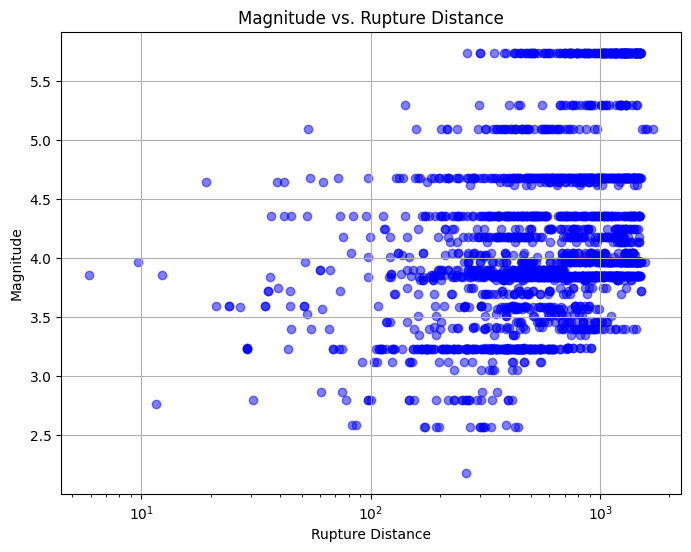

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X["Rrup"], X["Mw"], color='blue', alpha=0.5)
plt.xlabel('Rupture Distance')
plt.xscale('log')
plt.ylabel('Magnitude')
plt.title('Magnitude vs. Rupture Distance')
plt.grid(True)
plt.show()

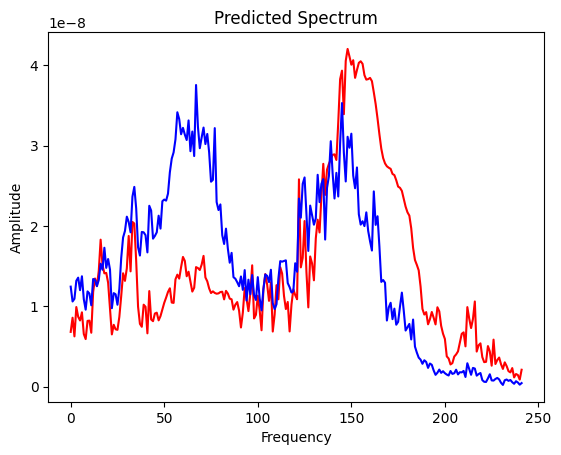

In [ ]:
import matplotlib.pyplot as plt

# Plot the predicted spectrum
plt.plot(actual.squeeze(), label='actual', color='red')
plt.plot(predicted_spectrum.squeeze(), label='Predicted', color='blue')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Predicted Spectrum')
plt.show()


In [19]:
# Pass the input data through the trained model to make a prediction
y_pred_1 = model_1.predict(X_test)
y_pred_1 = np.array(y_pred_1)

y_pred_2 = model_2.predict(X_test)
y_pred_2 = np.array(y_pred_2)

y_pred_3 = model_3.predict(X_test)
y_pred_3 = np.array(y_pred_3)

y_test = np.array(y_test)

In [ ]:
r2 = [0.82211, 0.82019, 0.82023]

In [20]:
r2 = [0.75227, 0.74733, 0.74437]

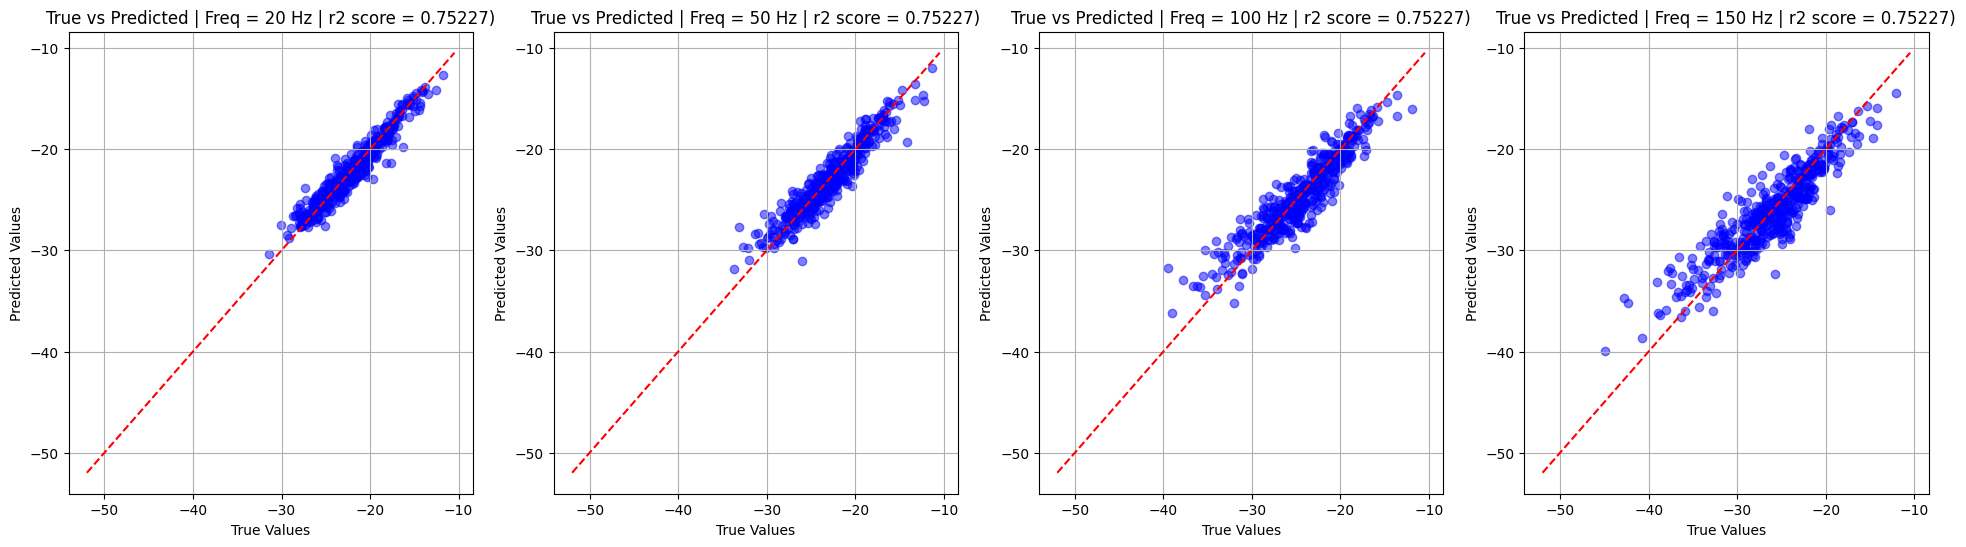

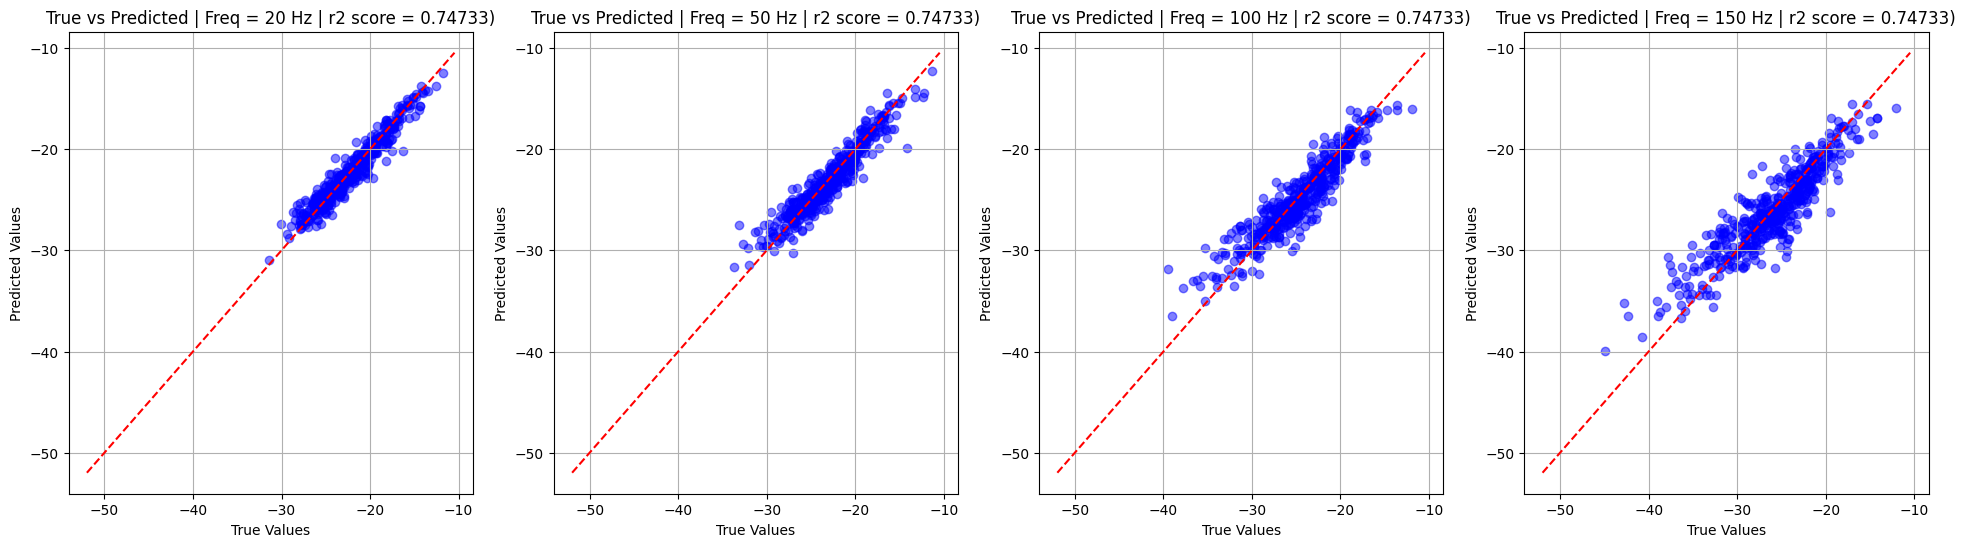

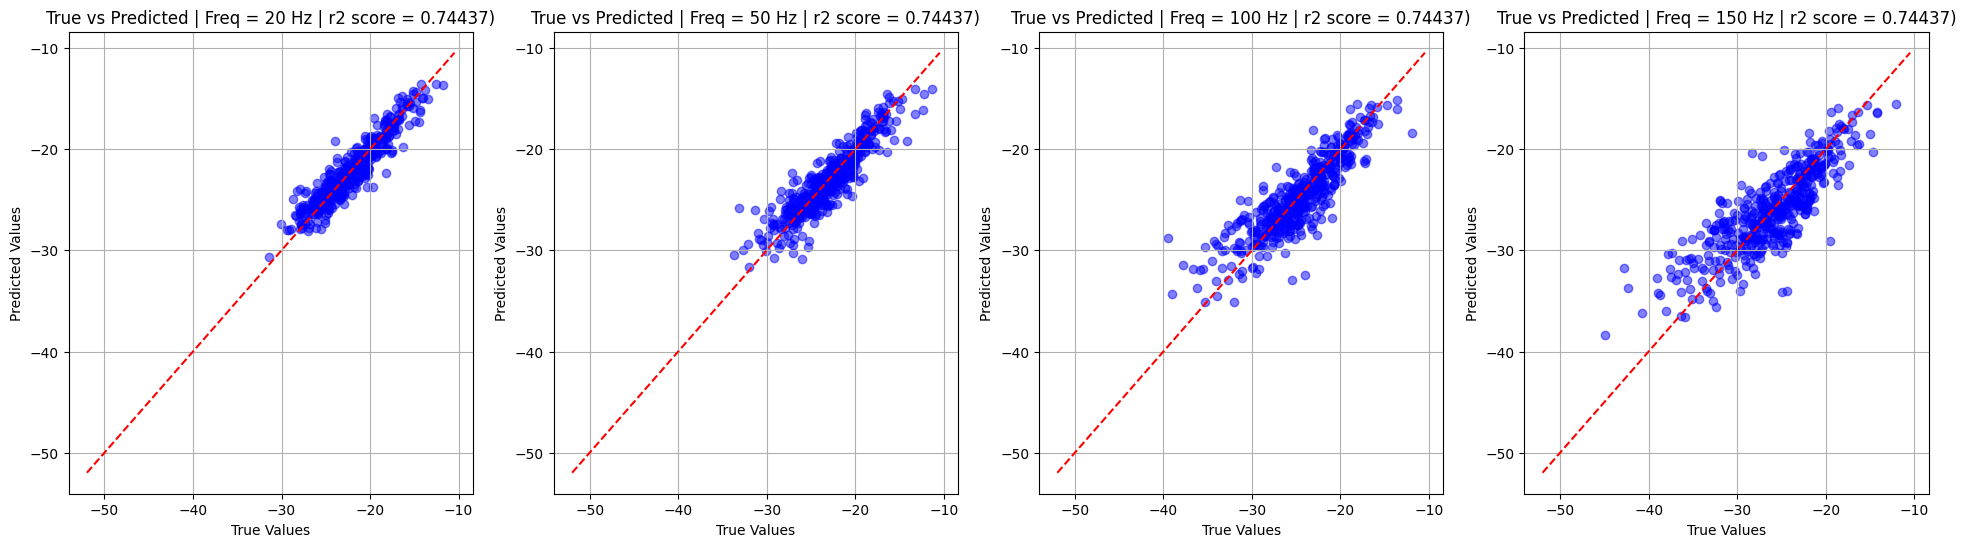

In [21]:
for j, pred in enumerate([y_pred_1, y_pred_2, y_pred_3]):
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    score = r2[j]

    for i, time in enumerate([20, 50, 100, 150]):
        axs[i].scatter([y_test[i, :][time] for i in range(len(y_test))], [pred[i, :][time] for i in range(len(pred))], color='blue', alpha=0.5)
        axs[i].plot([min(y_test.flatten()), max(y_test.flatten())], [min(y_test.flatten()), max(y_test.flatten())], color='red', linestyle='--')
        axs[i].set_xlabel('True Values')
        axs[i].set_ylabel('Predicted Values')
        axs[i].set_title(f'True vs Predicted | Freq = {time} Hz | r2 score = {score})')
        axs[i].grid(True)
    

In [22]:
# Pass the input data through the trained model to make a prediction
y_pred_1 = model_1.predict(X)
y_pred_1 = np.array(y_pred_1)

y = np.array(y)

In [23]:
magnitude = X["Mw"]


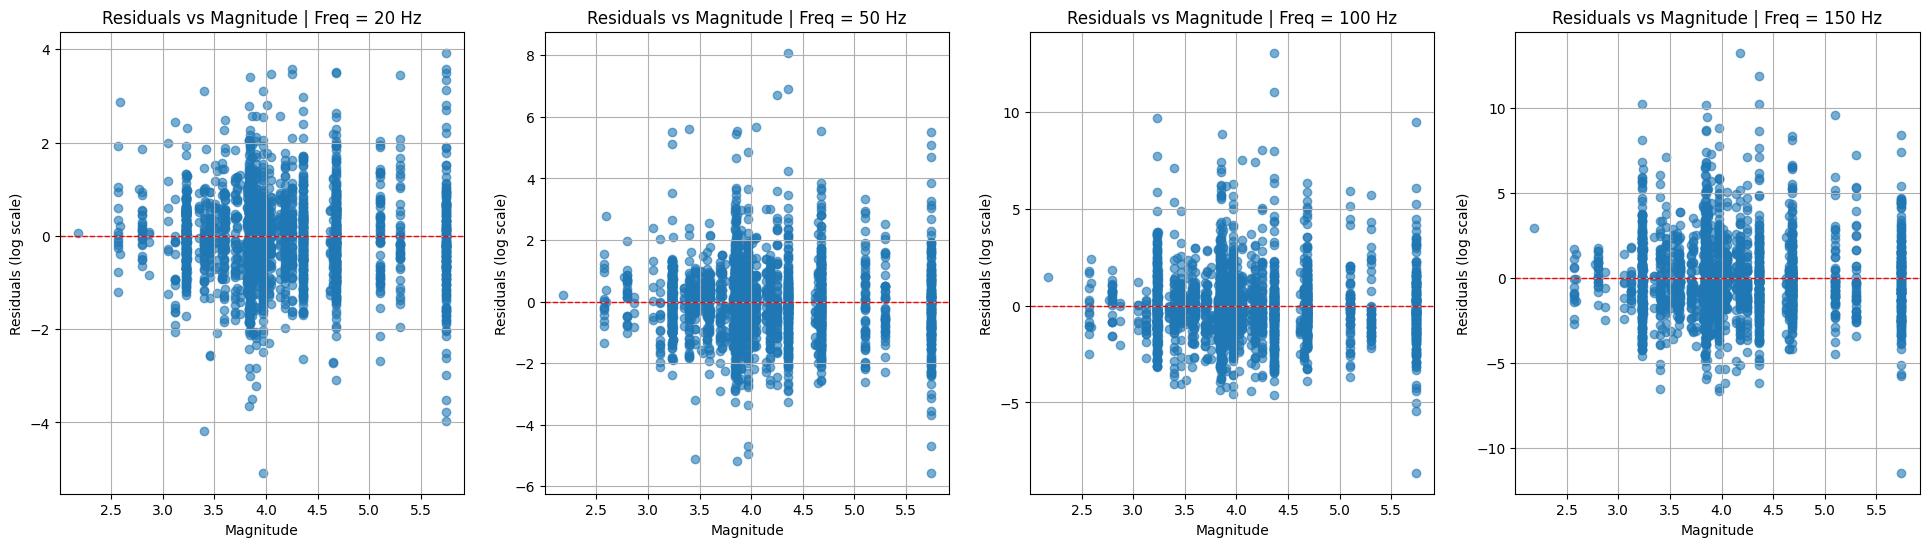

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))


for i, time in enumerate([20, 50, 100, 150]):
    residuals = y_pred_1[:, time] - y[:, time] 

    # Plot 1
    axs[i].scatter(magnitude, residuals, alpha=0.6)
    axs[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axs[i].set_xlabel('Magnitude')
    axs[i].set_ylabel('Residuals (log scale)')
    axs[i].set_title(f'Residuals vs Magnitude | Freq = {time} Hz')
    axs[i].grid(True)

In [25]:
Rrup_distance = X["Rrup"]


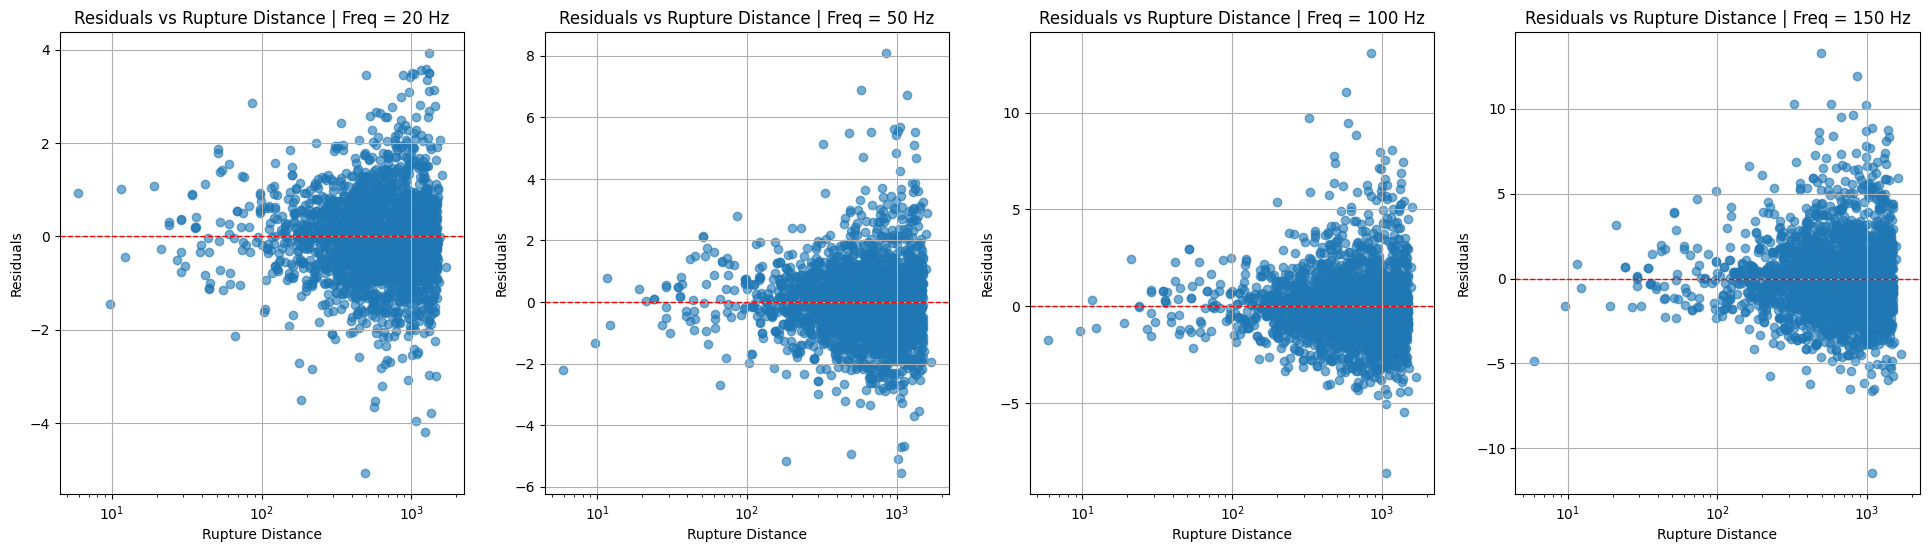

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))


for i, time in enumerate([20, 50, 100, 150]):
    residuals = y_pred_1[:, time] - y[:, time] 

    # Plot 1
    axs[i].scatter(Rrup_distance, residuals, alpha=0.6)
    axs[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axs[i].set_xlabel('Rupture Distance')
    axs[i].set_xscale('log')
    axs[i].set_ylabel('Residuals')
    axs[i].set_title(f'Residuals vs Rupture Distance | Freq = {time} Hz')
    axs[i].grid(True)

In [27]:
VS30 = np.exp(X["log(VS30)"])


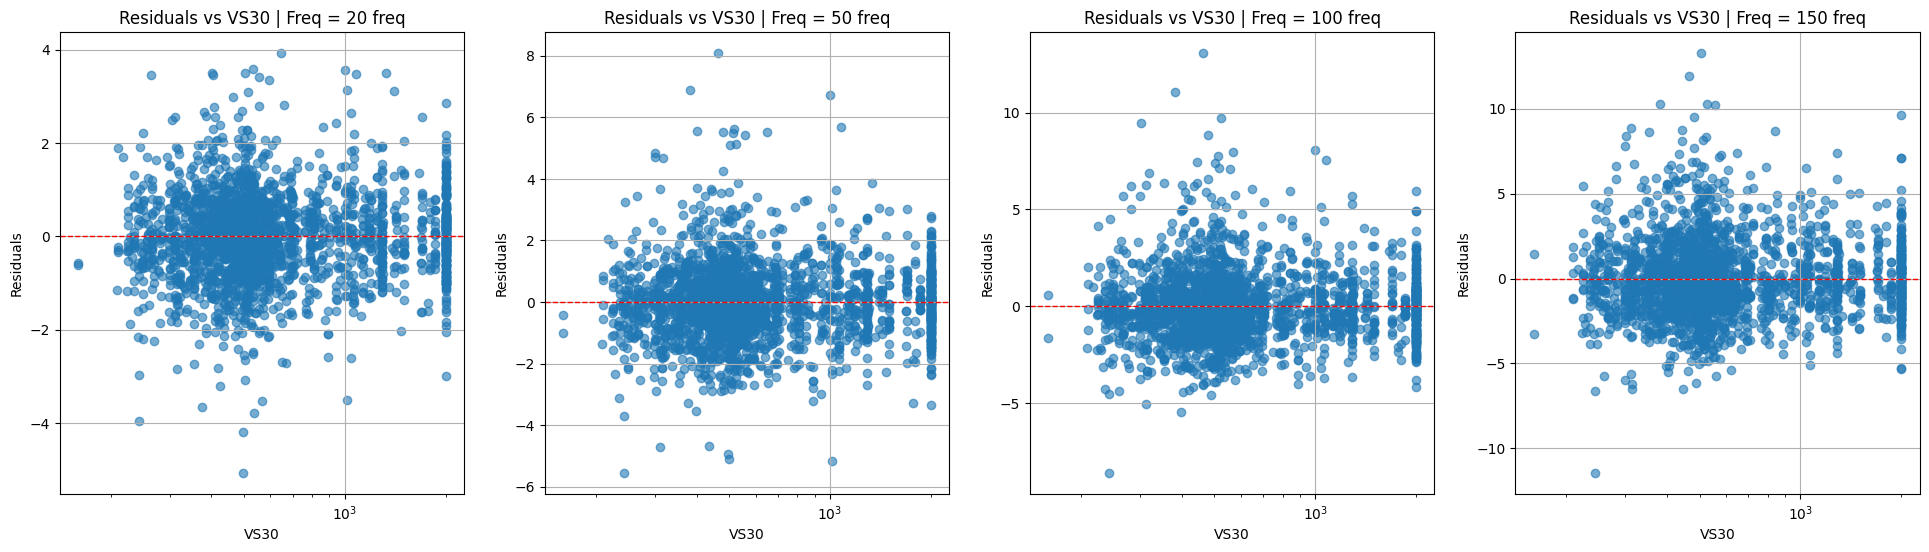

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))


for i, time in enumerate([20, 50, 100, 150]):
    residuals = y_pred_1[:, time] - y[:, time] 

    # Plot 1
    axs[i].scatter(VS30, residuals, alpha=0.6)
    axs[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axs[i].set_xlabel('VS30')
    axs[i].set_xscale('log')
    axs[i].set_ylabel('Residuals')
    axs[i].set_title(f'Residuals vs VS30 | Freq = {time} freq')
    axs[i].grid(True)

In [29]:
Mw_range = [(2.5, 3), (3.5, 4), (4, 4.5)]
R_range = [(0, 50), (100, 150), (150, 200)]

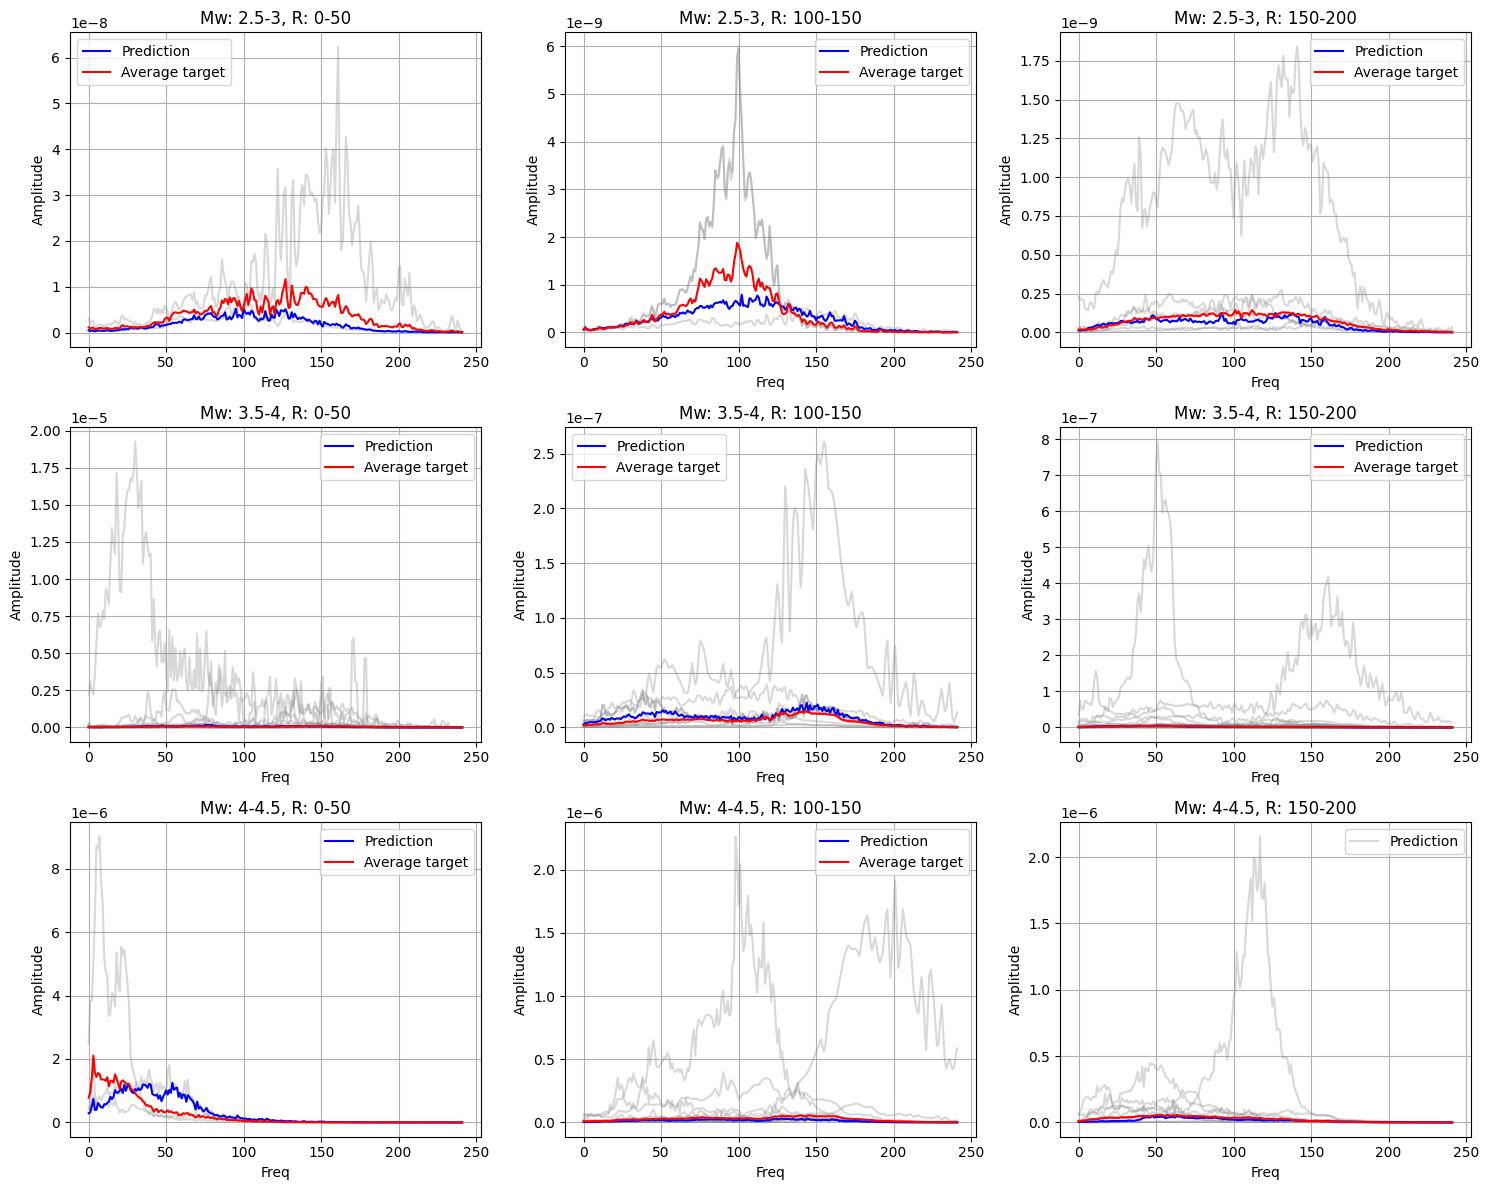

In [30]:
fig, axs = plt.subplots(len(Mw_range), len(R_range), figsize=(15, 12))

# Loop over Mw ranges
for i, (Mw_start, Mw_end) in enumerate(Mw_range):
    # Loop over R ranges
    for j, (R_start, R_end) in enumerate(R_range):
        # Filter the data based on the current range
        X_subset = X[(X["Mw"] >= Mw_start) & (X["Mw"] < Mw_end) & (X["Rrup"] >= R_start) & (X["Rrup"] < R_end)]
        y_subset = y[(X["Mw"] >= Mw_start) & (X["Mw"] < Mw_end) & (X["Rrup"] >= R_start) & (X["Rrup"] < R_end)]

        if X_subset.shape[0] == 0:
            continue
        
        # Predict the target values
        y_pred = model_1.predict(X_subset)

        
        for k in range(len(y_pred)):
            # axs[i, j].plot(np.exp(y_subset.iloc[i, :]), label='actual', color='red')
            axs[i, j].plot(np.exp(y_subset[k,:]), label=None, color='grey', alpha = 0.3)
        
        X_avg = np.average(X_subset, axis = 0)
        X_avg = np.expand_dims(X_avg, axis = 0)

        y_avg = np.average(y_subset, axis = 0)

        y_pred = model_1.predict(X_avg)
        y_pred = np.array(np.exp(y_pred))
        axs[i, j].plot(y_pred.flatten(), label=f'Prediction', color='blue')
        axs[i, j].plot(np.exp(y_avg), label = f"Average target", color="red")

        
        axs[i, j].set_xlabel('Freq')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Mw: {Mw_start}-{Mw_end}, R: {R_start}-{R_end}')
        axs[i, j].legend()
        axs[i, j].grid(True)

    dummy_line = plt.Line2D([], [], color='grey', alpha=0.3, label='Prediction')
    plt.legend(handles=[dummy_line], loc='upper right')


        
     

# Adjust layout
plt.tight_layout()
plt.show()